In [1]:
from Simulation.mpc import *
from Simulation.systemFunctions import DistillationColumnAspen
from utils.helpers import *

## Initialize the system

In [2]:
# System and Snapshot paths
path = r"C:\Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\C2S_SS_simulation8.dynf"
path_snaps = r"C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation8"

In [3]:
# First initiate the system
# Nominal Conditions
nominal_conditions =  np.array([1.50032484e+05, -2.10309105e+01, 2.08083248e+01, 6.30485237e-01, 3.69514734e-01, -2.40000000e+01])

# Steady State inputs
ss_inputs = np.array([320000.0, 110.0])

# Sampling time of the system
delta_t = 1 / 6 # 10 mins

In [4]:
# steady state values
dl = DistillationColumnAspen(path, ss_inputs, nominal_conditions)
steady_states={"ss_inputs":dl.ss_inputs,
               "y_ss":dl.y_ss}
print(steady_states)
dl.close(path_snaps)

Initialization has been completed
Steady State has been completed
System is in open loop condition now!
Steady state reached!
{'ss_inputs': array([3.2e+05, 1.1e+02]), 'y_ss': array([  0.1003974 , -22.95514339])}
Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation8\snpA0000.snp
Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation8\snpA0001.snp


## MPC implementation

## Loading the system matrices, min max scaling, and min max of the states

In [5]:
dir_path = os.path.join(os.getcwd(), "Data")

In [6]:
# Defining the range of setpoints for data generation
setpoint_y = np.array([[0.002, -26.0],
                       [0.05, -16.0]])
u_min = np.array([300000.0, 100.0])
u_max = np.array([460000, 150.0])

system_data = load_and_prepare_system_data(steady_states=steady_states, setpoint_y=setpoint_y, u_min=u_min, u_max=u_max)

In [7]:
A_aug = system_data["A_aug"]
B_aug = system_data["B_aug"]
C_aug = system_data["C_aug"]

In [8]:
data_min = system_data["data_min"]
data_max = system_data["data_max"]

In [9]:
min_max_states = system_data["min_max_states"]

In [10]:
y_sp_scaled_deviation = system_data["y_sp_scaled_deviation"]

In [11]:
b_min = system_data["b_min"]
b_max = system_data["b_max"]

In [12]:
min_max_dict = system_data["min_max_dict"]

In [31]:
# Setpoints in deviation form
inputs_number = int(B_aug.shape[1])
y_sp_scenario = np.array([[0.013, -23.],
                         [0.018, -22.]])

y_sp_scenario = (apply_min_max(y_sp_scenario, data_min[inputs_number:], data_max[inputs_number:])
                 - apply_min_max(steady_states["y_ss"], data_min[inputs_number:], data_max[inputs_number:]))

n_tests = 200
set_points_len = 400
TEST_CYCLE = [False, False, False, False, False]
warm_start = 10
ACTOR_FREEZE = 20 * set_points_len
warm_start_plot = warm_start * 2 * set_points_len + ACTOR_FREEZE

In [32]:
# # Observer Gain
poles = np.array([0.032, 0.03501095, 0.04099389, 0.04190188, 0.07477281,
                  0.01153274, 0.41036367])
L = compute_observer_gain(A_aug, C_aug, poles)
L

The system is observable.


C:\Users\HAMEDI\Desktop\DistillRL\Simulation\mpc.py:120: UserWarning: Convergence was not reached after maxiter iterations.
You asked for a tolerance of 0.001, we got 0.999717148453615.
  obs_gain_calc = signal.place_poles(A.T, C.T, desired_poles, method='KNV0')


array([[-1.28799695e-02, -5.59505811e-05],
       [ 1.52539626e-03,  6.80431625e-01],
       [-2.63810177e+00, -2.87660426e-03],
       [ 1.75971594e-04,  5.00909573e-04],
       [-1.48263212e-03, -6.61765392e-01],
       [ 5.07607473e+00,  4.18895490e-03],
       [ 1.72932845e-03,  2.14676215e+00]])

In [33]:
# MPC parameters
predict_h = 6
cont_h = 3
b1 = (b_min[0], b_max[0])
b2 = (b_min[1], b_max[1])
bnds = (b1, b2)*cont_h
cons = []
IC_opt = np.zeros(inputs_number*cont_h)
Q1_penalty = 1.
Q2_penalty = 1.
R1_penalty = 1.
R2_penalty = 1.

In [34]:
MPC_obj = MpcSolver(A_aug, B_aug, C_aug,
                    Q1_penalty, Q2_penalty, R1_penalty, R2_penalty,
                    predict_h, cont_h)

## Disturbance

In [35]:
def generate_disturbance_sequence(
    total_steps: int,
    nominal: float,
) -> np.ndarray:

    seq = np.linspace(nominal, nominal*1.05, total_steps)

    return seq

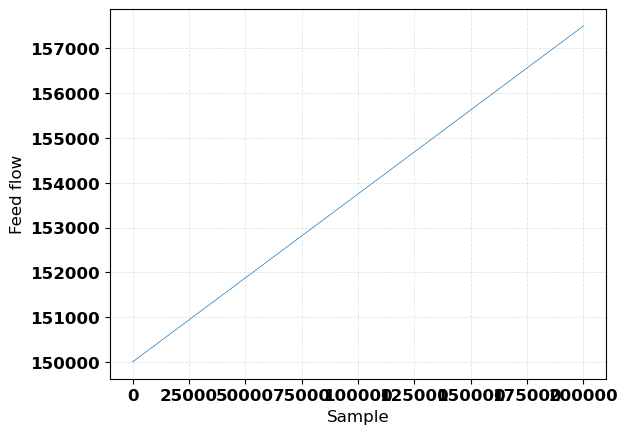

In [36]:
seq = generate_disturbance_sequence(
    total_steps        = 200_000,
    nominal            = 150_000,
)
plt.plot(seq, lw=0.5)
plt.xlabel("Sample")
plt.ylabel("Feed flow")
plt.show()

## Reward Function

In [37]:
def make_reward_fn_fixed_QR(
    data_min, data_max, n_inputs,
    y_band_phys,
    Q_diag, R_diag,
    tau_frac=0.5,
    gamma_out=0.20, gamma_in=0.30,
    beta=0.20, gate="geom", lam_in=1.0,
    bonus_kind="exp", bonus_k=8.0, bonus_p=0.6, bonus_c=20.0,
    bonus_scale_mode="qb2",
):

    data_min = np.asarray(data_min, float)
    data_max = np.asarray(data_max, float)
    dy = np.maximum(data_max[n_inputs:] - data_min[n_inputs:], 1e-12)  # phys per scaled

    y_band_phys = np.atleast_1d(np.asarray(y_band_phys, float))
    # convert plant band -> scaled band for this output scaling
    band_scaled = y_band_phys * dy
    print(band_scaled)
    tau_scaled  = tau_frac * band_scaled

    Q_diag = np.asarray(Q_diag, float)
    R_diag = np.asarray(R_diag, float)

    qb2 = Q_diag * (band_scaled**2)


    def _sigmoid(x):
        x = np.clip(x, -60.0, 60.0)
        return 1.0/(1.0 + np.exp(-x))

    def _phi(z, kind=bonus_kind, k=bonus_k, p=bonus_p, c=bonus_c):
        z = np.clip(z, 0.0, 1.0)
        if kind == "linear":   return 1.0 - z
        if kind == "quadratic":return (1.0 - z)**2
        if kind == "exp":      return (np.exp(-k*z) - np.exp(-k)) / (1.0 - np.exp(-k))
        if kind == "power":    return 1.0 - np.power(z, p)
        if kind == "log":      return np.log1p(c*(1.0 - z)) / np.log1p(c)
        raise ValueError("unknown bonus kind")

    def reward_fn(e_scaled, du_scaled):
        e_scaled = np.asarray(e_scaled, float)
        du_scaled= np.asarray(du_scaled, float)

        # ---- gating computed in *scaled* space (no plant conversion) ----
        abs_e = np.abs(e_scaled)
        s_i   = _sigmoid((band_scaled - abs_e) / np.maximum(tau_scaled, 1e-12))
        if gate == "prod":
            w_in = float(np.prod(s_i, dtype=np.float64))
        elif gate == "mean":
            w_in = float(np.mean(s_i))
        elif gate == "geom":
            w_in = float(np.prod(s_i, dtype=np.float64) ** (1.0/len(s_i)))
        else:
            raise ValueError("gate must be 'prod'|'mean'|'geom'")

        # ---- core MPC-like terms (scaled space) ----
        err_quad = np.sum(Q_diag * (e_scaled**2))
        err_eff  = (1.0 - w_in) * err_quad + w_in * (lam_in * err_quad)   # lam_in=1 -> no relief
        move     = np.sum(R_diag * (du_scaled**2))

        # ---- linear penalties calibrated by slope at the band edge ----
        # slope_i at |e|=b_i is 2 * Q_i * b_i  (same units as derivative of quadratic)
        slope_at_edge = 2.0 * Q_diag * band_scaled

        # outside: penalize only the overflow above the band
        overflow = np.maximum(abs_e - band_scaled, 0.0)
        lin_out  = (1.0 - w_in) * np.sum(gamma_out * slope_at_edge * overflow)

        # inside: penalize |e| linearly (optionally cap at b for stability)
        inside_mag = np.minimum(abs_e, band_scaled)
        lin_in     = w_in * np.sum(gamma_in * slope_at_edge * inside_mag)

        # ---- sharp inside bonus (dimensionless) using normalized scaled z = |e|/band ----
        z = abs_e / np.maximum(band_scaled, 1e-12)
        phi = _phi(z, kind=bonus_kind, k=bonus_k, p=bonus_p, c=bonus_c)
        bonus = w_in * beta * np.sum(qb2 * phi)

        return -(err_eff + move + lin_out + lin_in) + bonus

    return (
        dict(Q_diag=Q_diag, R_diag=R_diag, band_scaled=band_scaled, tau_scaled=tau_scaled,
             gamma_out=gamma_out, gamma_in=gamma_in, beta=beta, gate=gate, lam_in=lam_in,
             bonus_kind=bonus_kind, bonus_k=bonus_k, bonus_p=bonus_p, bonus_c=bonus_c,
             bonus_scale_mode=bonus_scale_mode),
        reward_fn
    )

## Reward configuration

In [38]:
Q_diag = np.array([100.0, 100.0])
R_diag = np.array([1.0, 1.0])

y_band_phys = np.array([0.002, 0.002])
print("Band scaled are:")

params, reward_fn = make_reward_fn_fixed_QR(
        data_min, data_max, inputs_number,
        y_band_phys,
        Q_diag, R_diag,
        tau_frac=0.2,
        gamma_out=.7, gamma_in=.7,
        beta=50., gate="prod", lam_in=1.0,
        bonus_kind="exp", bonus_k=4.0, bonus_p=0.6, bonus_c=20.0)
print(params)

Band scaled are:
[0.00106716 0.03562492]
{'Q_diag': array([100., 100.]), 'R_diag': array([1., 1.]), 'band_scaled': array([0.00106716, 0.03562492]), 'tau_scaled': array([0.00021343, 0.00712498]), 'gamma_out': 0.7, 'gamma_in': 0.7, 'beta': 50.0, 'gate': 'prod', 'lam_in': 1.0, 'bonus_kind': 'exp', 'bonus_k': 4.0, 'bonus_p': 0.6, 'bonus_c': 20.0, 'bonus_scale_mode': 'qb2'}


In [39]:
def run_mpc(system, MPC_obj, y_sp_scenario, n_tests, set_points_len,
            steady_states, IC_opt, bnds, cons,
            L, data_min, data_max,
            test_cycle, reward_fn,
            Q1_penalty, Q2_penalty, R1_penalty, R2_penalty):

    # defining setpoints
    y_sp, nFE, sub_episodes_changes_dict, time_in_sub_episodes = generate_setpoints(y_sp_scenario, n_tests,
                                                                                    set_points_len)

    # inputs and outputs of the system dimensions
    n_inputs = B_aug.shape[1]
    n_outputs = C_aug.shape[0]
    n_states = A_aug.shape[0]

    # Scaled steady states inputs and outputs
    ss_scaled_inputs = apply_min_max(steady_states["ss_inputs"], data_min[:n_inputs], data_max[:n_inputs])
    y_ss_scaled = apply_min_max(steady_states["y_ss"], data_min[n_inputs:], data_max[n_inputs:])

    y_mpc = np.zeros((nFE + 1, n_outputs))
    y_mpc[0, :] = system.current_output
    u_mpc = np.zeros((nFE, n_inputs))
    yhat = np.zeros((n_outputs, nFE))
    xhatdhat = np.zeros((n_states, nFE + 1))
    xhatdhat[:, 0] = np.random.uniform(low=min_max_dict["x_min"], high=min_max_dict["x_max"])
    rewards = np.zeros(nFE)
    rewards_mpc = np.zeros(nFE)
    avg_rewards = []
    avg_rewards_mpc = []

    # Recording
    delta_y_storage, delta_u_storage = [], []

    # Disturbances
    dist = generate_disturbance_sequence(
        total_steps=nFE,
        nominal=150_000,
    )

    for i in range(nFE):
        # Current scaled input & deviation
        scaled_current_input = apply_min_max(system.current_input, data_min[:n_inputs], data_max[:n_inputs])
        scaled_current_input_dev = scaled_current_input - ss_scaled_inputs

        # Solving MPC optimization problem
        sol = spo.minimize(
            lambda x: MPC_obj.mpc_opt_fun(x, y_sp[i, :], scaled_current_input_dev,
                                          xhatdhat[:, i]), IC_opt, bounds=bnds, constraints=cons)

        # take the first control action (this is in scaled deviation form)
        u_mpc[i, :] = sol.x[:MPC_obj.B.shape[1]] + ss_scaled_inputs

        # u (reverse scaling of the mpc)
        u_plant = reverse_min_max(u_mpc[i, :], data_min[:n_inputs], data_max[:n_inputs])

        # delta u cost variables
        delta_u = u_mpc[i, :] - scaled_current_input

        # Apply to plant and step
        system.current_input = u_plant
        system.step(disturbances=np.array([dist[i]]))

        # Record the system output
        y_mpc[i+1, :] = system.current_output

        # ----- Observer & model roll -----
        y_current_scaled = apply_min_max(y_mpc[i+1, :], data_min[n_inputs:], data_max[n_inputs:]) - y_ss_scaled
        y_prev_scaled = apply_min_max(y_mpc[i, :], data_min[n_inputs:], data_max[n_inputs:]) - y_ss_scaled

        # Calculate Delta y in deviation form
        delta_y = y_current_scaled - y_sp[i, :]

        # Calculate the next state in deviation form
        yhat[:, i] = np.dot(MPC_obj.C, xhatdhat[:, i])
        xhatdhat[:, i+1] = np.dot(MPC_obj.A, xhatdhat[:, i]) + np.dot(MPC_obj.B, (u_mpc[i, :] - ss_scaled_inputs)) + np.dot(L, (y_prev_scaled - yhat[:, i])).T

        # Reward Calculation
        reward = reward_fn(delta_y, delta_u)

        # Reward MPC
        reward_mpc = - (Q1_penalty * delta_y[0] ** 2 + Q2_penalty * delta_y[1] ** 2 +
                        R1_penalty * delta_u[0] ** 2 + R2_penalty * delta_u[1] ** 2)

        # Recording
        rewards[i] = reward
        rewards_mpc[i] = reward_mpc
        delta_y_storage.append(delta_y)
        delta_u_storage.append(delta_u)

        # Calculate average reward and printing
        if i in sub_episodes_changes_dict.keys():
            # Averaging the rewards from the last setpoint change till curtrent
            avg_rewards.append(np.mean(rewards[i - time_in_sub_episodes + 1: i]))
            avg_rewards_mpc.append(np.mean(rewards_mpc[i - time_in_sub_episodes + 1: i]))

            # printing
            print('Sub_Episode : ', sub_episodes_changes_dict[i], ' | avg. reward :', avg_rewards[-1], ' | avg. reward MPC :', avg_rewards_mpc[-1])

    u_mpc = reverse_min_max(u_mpc, data_min[:n_inputs], data_max[:n_inputs])

    return y_mpc, u_mpc, avg_rewards, rewards, xhatdhat, nFE, time_in_sub_episodes, y_sp, yhat, delta_y_storage, delta_u_storage, rewards_mpc, avg_rewards_mpc, dist

In [ ]:
dl = DistillationColumnAspen(path, ss_inputs, nominal_conditions)
y_mpc, u_mpc, avg_rewards, rewards, xhatdhat, nFE, time_in_sub_episodes, y_sp, yhat, delta_y_storage, delta_u_storage, rewards_mpc, avg_rewards_mpc, dist = run_mpc(dl, MPC_obj, y_sp_scenario, n_tests, set_points_len,
            steady_states, IC_opt, bnds, cons,
            L, data_min, data_max,
            TEST_CYCLE, reward_fn,
            Q1_penalty, Q2_penalty, R1_penalty, R2_penalty)
dl.close(path_snaps)

Initialization has been completed
Steady State has been completed
System is in open loop condition now!
Steady state reached!
Sub_Episode :  1  | avg. reward : 4.215461203191701  | avg. reward MPC : -0.006112351074139915
Sub_Episode :  2  | avg. reward : 4.927421007741585  | avg. reward MPC : -4.956016628580816e-05
Sub_Episode :  3  | avg. reward : 4.926311433660976  | avg. reward MPC : -4.923556188803138e-05


In [28]:
def plot_mpc_results(
    y_sp, steady_states, nFE, delta_t, time_in_sub_episodes,
    y_mpc, u_mpc, avg_rewards, data_min, data_max, xhatdhat, yhat=None,
    directory=None, prefix_name="mpc_result"
):
    """
    Paper-ready MPC figures; saves to directory/prefix_name/<timestamp>/.
    Logic unchanged (only plotting & saving).
    Returns: out_dir (str)
    """
    import os
    from datetime import datetime
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.ticker as mtick

    # ---------- output directory ----------
    if directory is None:
        directory = os.getcwd()
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    out_dir = os.path.join(directory, prefix_name, timestamp)
    os.makedirs(out_dir, exist_ok=True)

    # ---------- helper: save current figure as PNG+PDF ----------
    def _savefig(name_base):
        plt.tight_layout()
        png = os.path.join(out_dir, f"{name_base}.png")
        pdf = os.path.join(out_dir, f"{name_base}.pdf")
        plt.savefig(png, bbox_inches='tight', dpi=300)
        plt.savefig(pdf, bbox_inches='tight')
        plt.close()

    # ---------- your original scaling logic (unchanged) ----------
    y_ss = apply_min_max(steady_states["y_ss"], data_min[2:], data_max[2:])
    y_sp = (y_sp + y_ss)
    y_sp = (reverse_min_max(y_sp, data_min[2:], data_max[2:])).T

    # ---------- style (paper) ----------
    mpl.rcParams.update({
        "font.size": 12,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "legend.frameon": True,
    })
    C_MPC = "tab:blue"
    C_SP  = "tab:red"
    C_R   = "tab:green"   # reflux
    C_QR  = "tab:orange"  # reboiler duty

    ####### Plot 1 (full horizon) ################################
    time_plot = np.linspace(0, nFE * delta_t, nFE + 1)
    time_plot_hour = np.linspace(0, time_in_sub_episodes * delta_t, time_in_sub_episodes + 1)

    fig = plt.figure(figsize=(7.6, 5.2))
    # Tray 23 C2H6 composition
    ax = plt.subplot(2, 1, 1)
    ax.plot(time_plot, y_mpc[:, 0], '-', lw=2.2, color=C_MPC, label=r'MPC', zorder=2)
    ax.step(time_plot[:-1], y_sp[0, :], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label=r'Setpoint', zorder=3)
    ax.set_ylabel(r'$x_{23,\mathrm{C_2H_6}}$ (–)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.set_xlim(0, time_plot[-1])
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.tick_params(axis='x', pad=4)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., facecolor='white')

    # Tray 85 Temperature
    ax = plt.subplot(2, 1, 2)
    ax.plot(time_plot, y_mpc[:, 1], '-', lw=2.2, color=C_MPC, label=r'MPC', zorder=2)
    ax.step(time_plot[:-1], y_sp[1, :], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label=r'Setpoint', zorder=3)
    ax.set_ylabel(r'$T_{85}$ (K)'); ax.set_xlabel('Time (h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.set_xlim(0, time_plot[-1])
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.tick_params(axis='x', pad=4)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., facecolor='white')

    plt.gcf().subplots_adjust(right=0.82)
    _savefig('fig_mpc_outputs_full')

    ########### Plot 1b (last window = time_in_sub_episodes) #####
    fig = plt.figure(figsize=(7.6, 5.2))
    # Tray 23 C2H6 composition
    ax = plt.subplot(2, 1, 1)
    ax.plot(time_plot_hour, y_mpc[nFE - time_in_sub_episodes:, 0], '-', lw=2.2, color=C_MPC, label=r'MPC', zorder=2)
    ax.step(time_plot_hour[:-1], y_sp[0, nFE - time_in_sub_episodes:], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label=r'Setpoint', zorder=3)
    ax.set_ylabel(r'$x_{23,\mathrm{C_2H_6}}$ (–)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., facecolor='white')

    # Tray 85 Temperature
    ax = plt.subplot(2, 1, 2)
    ax.plot(time_plot_hour, y_mpc[nFE - time_in_sub_episodes:, 1], '-', lw=2.2, color=C_MPC, label=r'MPC', zorder=2)
    ax.step(time_plot_hour[:-1], y_sp[1, nFE - time_in_sub_episodes:], where='post', linestyle='--', lw=2.2, color=C_SP, alpha=0.95, label=r'Setpoint', zorder=3)
    ax.set_ylabel(r'$T_{85}$ (K)'); ax.set_xlabel('Time (h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., facecolor='white')

    plt.gcf().subplots_adjust(right=0.82)
    _savefig(f'fig_mpc_outputs_last{time_in_sub_episodes}')

    ####### Plot 2 (inputs over full horizon) #####################
    fig = plt.figure(figsize=(7.6, 5.2))
    # Reflux R
    ax = plt.subplot(2, 1, 1)
    ax.step(time_plot[:-1], u_mpc[:, 0], where='post', lw=2.2, color=C_R, label=r'$R$', zorder=2)
    ax.set_ylabel(r'$R$ (kg/h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., facecolor='white')

    # Reboiler duty Q_r
    ax = plt.subplot(2, 1, 2)
    ax.step(time_plot[:-1], u_mpc[:, 1], where='post', lw=2.2, color=C_QR, label=r'$Q_r$', zorder=2)
    ax.set_ylabel(r'$Q_r$ (GJ/h)'); ax.set_xlabel('Time (h)')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0., facecolor='white')

    plt.gcf().subplots_adjust(right=0.82)
    _savefig('fig_mpc_inputs_full')

    return out_dir

In [29]:
plot_mpc_results(
    y_sp, steady_states, nFE, delta_t, time_in_sub_episodes,
    y_mpc, u_mpc, avg_rewards, data_min, data_max, xhatdhat, yhat=None,
    directory=dir_path, prefix_name="mpc_result_dist"
)

'C:\\Users\\HAMEDI\\Desktop\\DistillRL\\Data\\mpc_result_dist\\20250915_164440'

In [30]:
# Storing the inputs and outputs of the MPC
mpc_results = {
    "u_mpc": u_mpc,
    "y_mpc": y_mpc,
    "avg_rewards": avg_rewards,
    "avg_rewards_mpc": avg_rewards_mpc,
    "xhatdhat": xhatdhat,
    "delta_y_storage": delta_y_storage,
    "delat_u_storage": delta_u_storage
}
save_path = os.path.join(dir_path, "mpc_results_dist.pickle")
with open(save_path, 'wb') as file:
    pickle.dump(mpc_results, file)